##Installation (if needed)

In [ ]:
!pip install pyfaidx

##Importing Libraries

In [ ]:
import pandas as pd
from pyfaidx import Fasta
from collections import Counter
import itertools
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/tcga_brca_mutations.csv")
print("Rows:", len(df))
df.columns

Rows: 89568


Index(['Gene', 'Chromosome', 'Position', 'Ref', 'Alt', 'Classification'], dtype='object')

In [ ]:
# Confirm column names and preview first few rows
assert 'Gene' in df.columns or 'Hugo_Symbol' in df.columns, "Gene column missing!"

# Rename if needed
if 'Hugo_Symbol' in df.columns:
    df.rename(columns={'Hugo_Symbol': 'Gene'}, inplace=True)

df.head()

,Gene,Chromosome,Position,Ref,Alt,Classification
0,MIB2,chr1,1625276,CCCTCCGCAGGCAAGCCGGCGGAG,-,Splice_Site
1,VPS13D,chr1,12283654,T,C,Missense_Mutation
2,PRAMEF8,chr1,13281907,C,A,Missense_Mutation
3,NBPF1,chr1,16576355,C,G,Missense_Mutation
4,SRSF4,chr1,29148880,C,T,Missense_Mutation


In [ ]:
# Drop missing critical fields
df = df.dropna(subset=['Gene', 'Chromosome', 'Position'])

# Standardize chromosome format
df['Chromosome'] = df['Chromosome'].astype(str).str.replace('chr', '').str.strip()

# Keep valid chromosomes
df = df[df['Chromosome'].isin([str(i) for i in range(1, 23)] + ['X', 'Y'])]

print("Filtered rows:", len(df))

Filtered rows: 89568


####Extract ±20bp Sequence Context

In [ ]:
# Load reference genome
genome = Fasta("/content/drive/MyDrive/GRCh38.fa")

def get_context(chrom, pos, flank=20):
    try:
        return genome[chrom][int(pos)-flank-1:int(pos)+flank].seq
    except:
        return None

df['Context'] = df.apply(lambda row: get_context(row['Chromosome'], row['Position']), axis=1)
df = df.dropna(subset=['Context'])
print("Rows with valid context:", len(df))


Rows with valid context: 89568


In [ ]:
cgc = pd.read_csv("/content/drive/MyDrive/Census_all.csv")

In [ ]:
cgc.columns.tolist()

['Gene Symbol',
 'Name',
 'Entrez GeneId',
 'Genome Location',
 'Tier',
 'Hallmark',
 'Chr Band',
 'Somatic',
 'Germline',
 'Tumour Types(Somatic)',
 'Tumour Types(Germline)',
 'Cancer Syndrome',
 'Tissue Type',
 'Molecular Genetics',
 'Role in Cancer',
 'Mutation Types',
 'Translocation Partner',
 'Other Germline Mut',
 'Other Syndrome',
 'Synonyms']

In [ ]:
cgc['Tier'].unique()

array([2, 1])

In [ ]:
cgc['Tier'] = cgc['Tier'].astype(str).str.strip()  # remove spaces
cgc_filtered = cgc[cgc['Tier'].isin(['1', '2'])]
driver_genes = set(cgc_filtered['Gene Symbol'].dropna().str.upper())
print("Number of driver genes:", len(driver_genes))

Number of driver genes: 758


####Normalize Gene Names and Assign Driver Labels

In [ ]:
df['Gene'] = df['Gene'].astype(str).str.strip().str.upper()
df['IsDriver'] = df['Gene'].isin(driver_genes)
df['Label'] = df['IsDriver'].astype(int)

In [ ]:
#check class imbalance
df['Label'].value_counts()

,count
Label,
0,81887
1,7681


##k-mer feature extraction

In [ ]:
# Generate all possible 3-mers
bases = ['A', 'C', 'G', 'T']
kmers = [''.join(p) for p in itertools.product(bases, repeat=3)]

def extract_kmer_counts(seq, k=3):
    seq = seq.upper()
    kmer_counts = Counter([seq[i:i+k] for i in range(len(seq)-k+1)])
    return [kmer_counts.get(kmer, 0) for kmer in kmers]

# Apply to all sequences
kmer_features = np.array(df['Context'].apply(extract_kmer_counts).tolist())

In [ ]:
X = kmer_features
y = df['Label'].values

print("X shape:", X.shape)
print("y distribution:", np.bincount(y))

X shape: (89568, 64)
y distribution: [81887  7681]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

#Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

#Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

#Predict and evaluate
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0      0.927     1.000     0.962     16378
           1      0.996     0.157     0.271      1536

    accuracy                          0.928     17914
   macro avg      0.961     0.578     0.617     17914
weighted avg      0.933     0.928     0.903     17914

AUC: 0.6322428484794135
Confusion Matrix:
 [[16377     1]
 [ 1295   241]]


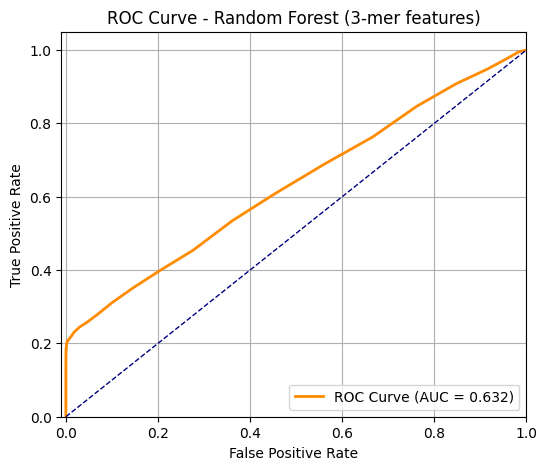

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#FPR, TPR for thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (3-mer features)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

#####Observations

- The ROC curve is only slightly above the diagonal (random guessing line), which indicates'
    - The model has some ability to distinguish between driver and non-driver mutations.
    - But it's not a strong classifier — AUC of 0.63 is low for reliable predictions.


- A perfect recall for non-drivers indicates that the model memorized the background mutations pattern well.

- A low recall for drivers indicates the struggle of the model to detect the true driver mutations.

- Also, the 3-mer features are too shallow. So the local sequence alosne doesn't carry enough discriminative signal for cancer-driving mutations.

####One-hot Encoding

In [ ]:
import numpy as np

# Define one-hot mapping
base_map = {'A': [1, 0, 0, 0],
            'C': [0, 1, 0, 0],
            'G': [0, 0, 1, 0],
            'T': [0, 0, 0, 1],
            'N': [0, 0, 0, 0]}  # for unknown bases

def one_hot_encode(seq):
    return np.array([base_map.get(base, [0, 0, 0, 0]) for base in seq.upper()])

X_seq = np.stack(df['Context'].apply(one_hot_encode).values)
y_seq = df['Label'].values

print("Shape:", X_seq.shape)

Shape: (89568, 41, 4)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(41, 4)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=2
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
504/504 - 27s - 53ms/step - accuracy: 0.8926 - auc: 0.5054 - loss: 0.3892 - val_accuracy: 0.8141 - val_auc: 0.5302 - val_loss: 0.5276
Epoch 2/20
504/504 - 38s - 75ms/step - accuracy: 0.9131 - auc: 0.5250 - loss: 0.3205 - val_accuracy: 0.9171 - val_auc: 0.5343 - val_loss: 0.3269
Epoch 3/20
504/504 - 21s - 42ms/step - accuracy: 0.9146 - auc: 0.5343 - loss: 0.3080 - val_accuracy: 0.9178 - val_auc: 0.5418 - val_loss: 0.3237
Epoch 4/20
504/504 - 40s - 80ms/step - accuracy: 0.9150 - auc: 0.5389 - loss: 0.3035 - val_accuracy: 0.9178 - val_auc: 0.5392 - val_loss: 0.3195
Epoch 5/20
504/504 - 40s - 79ms/step - accuracy: 0.9153 - auc: 0.5458 - loss: 0.3000 - val_accuracy: 0.9178 - val_auc: 0.5380 - val_loss: 0.3202
Epoch 6/20
504/504 - 18s - 36ms/step - accuracy: 0.9156 - auc: 0.5444 - loss: 0.2989 - val_accuracy: 0.9178 - val_auc: 0.5435 - val_loss: 0.3227
Epoch 7/20
504/504 - 18s - 36ms/step - accuracy: 0.9159 - auc: 0.5538 - loss: 0.2959 - val_accuracy: 0.9185 - val_auc: 0.5485 - va

In [ ]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

560/560 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9172 - auc: 0.5679 - loss: 0.3040

Test Accuracy: 0.917
Test AUC: 0.572


####Observations

- Misleading high accuracy
    - The dataset is imbalanced (mostly non-drivers)
    - The model is likely biased toward predicting class 0 (passenger)

- Low AUC Score (0.57)
    - Poor separation between driver and non-driver mutations
    - The model struggles to generalize beyond background noise in sequence

####Adding more features

In [ ]:
df['MutationType'] = df['Classification'].astype(str).str.strip().str.lower()
mutation_dummies = pd.get_dummies(df['MutationType'], prefix='mut')

In [ ]:
role_map = cgc.set_index('Gene Symbol')['Role in Cancer'].to_dict()
df['GeneRole'] = df['Gene'].map(role_map).fillna('unknown')
role_dummies = pd.get_dummies(df['GeneRole'], prefix='role')

In [ ]:
# Combine all features into a single matrix
X_extended = np.hstack([
    kmer_features,
    mutation_dummies.values,
    role_dummies.values
])

In [ ]:
df.head()

,Gene,Chromosome,Position,Ref,Alt,Classification,Context,IsDriver,Label,MutationType,GeneRole
0,MIB2,1,1625276,CCCTCCGCAGGCAAGCCGGCGGAG,-,Splice_Site,GCCTGAGGCCTGGTCTGCCACCCTCCGCAGGCAAGCCGGCG,False,0,splice_site,unknown
1,VPS13D,1,12283654,T,C,Missense_Mutation,GAGGCTGCCTCCTGAGGGCATTCTGCACAACGTGAAGTTGG,False,0,missense_mutation,unknown
2,PRAMEF8,1,13281907,C,A,Missense_Mutation,CAGGCAGTCGGTCATAACGACCATCTCCAAGGAGGCCTGGA,False,0,missense_mutation,unknown
3,NBPF1,1,16576355,C,G,Missense_Mutation,TGCCCCTGGGACTTGTCTGGCTCATCCGGAGTGAGGAGGGC,False,0,missense_mutation,unknown
4,SRSF4,1,29148880,C,T,Missense_Mutation,CCTGCTCCGGCTCCTGCTGCCCCCTTTGCTCCTGCTCCGGC,False,0,missense_mutation,unknown


In [ ]:
y_extended = df['Label'].values

print("Extended feature shape:", X_extended.shape)

Extended feature shape: (89568, 91)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X_extended, y_extended, stratify=y_extended, test_size=0.2, random_state=42
)

rf_ext = RandomForestClassifier(n_estimators=100, random_state=42)
rf_ext.fit(X_train, y_train)

y_pred = rf_ext.predict(X_test)
y_prob = rf_ext.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0      0.995     1.000     0.998     16378
           1      1.000     0.947     0.973      1536

    accuracy                          0.995     17914
   macro avg      0.998     0.974     0.985     17914
weighted avg      0.996     0.995     0.995     17914

AUC: 0.9785028848086356


###Observations


**The Random Forest was able to learn highly discriminative patterns from this combined feature space — especially when you labeled mutations at the gene level using COSMIC.**